In [ ]:

#What is the main question you want to answer? 
#How do you plan to answer it? 
#What other questions do you think you might answer along the way?



# What will your code be doing? 
# For this section, we’re looking for a high-level 
# Explanation of what your code is going to do rather than implementation details. 
# We are not looking for specifics like for loops, conditionals, loading data, et cetera, 
# but rather big picture things like functions that will handle retrieving data from an API or process a series of text files.


# What are the anticipated roadblocks you might encounter? 
# If you do encounter them, how do you think you’ll overcome them?


#What visualizations will be useful in explaining your results? 
#Provide some sketches of how you think your visualizations might look.


In [673]:
# overall project plan꞉
# Load Data from Countrys CSV
# Gather nessisary data from FBI API
# Comapre data sets too match each person with a specific coordenate
# Create map using folium and plot the data
# Create charts to view individual countrys impact too the FBI Most Wanted List
# Begin scraping the FBI Most Wanted Wiki (This is the majority of my time was spent)
# Track the united states affectiveness of caputuring criminals over the years
# Have they been improving?
#
#
#
#

# Side Notes:
# It looks like a lot of code, but most of it was copy and pasting from prior blocks I made
#


###WORKS### - is just a header I put to show what block work and dont, it helped me stay organized.

In [721]:
# Imports ###WORKS###
import requests
import json
import pandas as pd
import folium
import matplotlib.pyplot as plt
from IPython.display import display
import re
from bs4 import BeautifulSoup

In [677]:
# Block 1: Import libraries and setup API function ###WORKS### 
def fetchFbiData(page=1):
    #Fetch data from FBI Most Wanted API
    try:
        response = requests.get('https://api.fbi.gov/wanted/v1/', params={'page': page})
        # json.loads() parses a json string and converts it into data structures     
        return json.loads(response.content)
    except:
        # Return empty data structure on any error
        return {"items": []}

In [679]:
# Block 2: Load Coordinate Data ###WORKS### 
# this part took so long, becuase I had to use some fancy functions (notna, isna, iterrows)
# isna() checks is both not a missing value and contains anything
# notna() is opposite of isna
# iterrows() allows you to loop through a DataFrame row by row


def loadCoordinateData(csvFilePath):
    
    # Step 1: Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csvFilePath)
    
    # Step 2: Create empty dictionaries to store our coordinate data
    countries = {}  # Will store country coordinates
    usStates = {}  # Will store US state coordinates
    
    # Step 3: Extract country data from the CSV
    # Filter to only rows with country data and select only the columns we need
    countryData = df[df['country'].notna()][['country', 'latitude', 'longitude']].drop_duplicates()
    
    # Loop through each country row
    for index, row in countryData.iterrows():
        # Get the country name
        countryName = row['country']
        
        
        # Checks that the state name variable is not a missing value
        # and contains actual content before proceeding with the code.
        if not pd.isna(countryName) and countryName: 
            # Store country coordinates as a tuple (latitude, longitude)
            countries[countryName] = (row['latitude'], row['longitude'])
    
    # Step 4: Extract US state data from the CSV
    # filters the dataframe to rows where the state name is not missing, 
    # selects only the three columns with state data, and removes any duplicate state entries.
    stateData = df[df['usa_state'].notna()][['usa_state', 'usa_state_latitude', 'usa_state_longitude']].drop_duplicates()  
    

    for index, row in stateData.iterrows(): 
        # Get the state name
        stateName = row['usa_state']
        
        # Make sure the state name is valid
        if not pd.isna(stateName) and stateName:
            # Store state name in UPPERCASE for easier matching later
            # Store state coordinates as a tuple (latitude, longitude)
            usStates[stateName.upper()] = (row['usa_state_latitude'], row['usa_state_longitude'])
    
    # Step 5: Print how many countries and states we loaded
    print("Loaded " + str(len(countries)) +" countries and " + str(len(usStates)) + " US states from CSV.")
    
    # Adding common aliases for countries that might appear in FBI data
    # Add "United States of America" as alias for "United States"
    if ('United States' in countries) and ('United States of America' not in countries):
        countries['United States of America'] = countries['United States']
    
    # Add "UK" and "England" as aliases for "United Kingdom"
    if 'United Kingdom' in countries:
        countries['UK'] = countries['United Kingdom']
        countries['England'] = countries['United Kingdom']
    
    return countries, usStates
    
# Load coordinate data from CSV
countries, usStates = loadCoordinateData("world_country_and_usa_states_latitude_and_longitude_values.csv")
    

Loaded 245 countries and 52 US states from CSV.


In [681]:
#Block 3A: processFbiData ###WORKS### 

# Helper function to add location data
def addToData(dataDict, locationName, coordinates):
    #Add or update location data in the specified dictionary
    latitude, longitude = coordinates
    
    if locationName in dataDict:
        dataDict[locationName]['count'] += 1
    else:
        dataDict[locationName] = {
            'latitude': latitude,
            'longitude': longitude,
            'count': 1
        }


def processFbiData(countries, usStates, totalToProcess=400, maxPeopleToCheck=700):
    #Process FBI API data to extract location information
    
    # Initialize data containers
    countryData = {}  # Stores country counts and coordinates
    stateData = {}    # Stores state counts and coordinates
    processedCount = 0
    peopleChecked = 0
    currentPage = 1
    currentIndex = 0
    
    # Map of field offices to states - used as last resort Check 3
    # Here I used chat gpt to make this dictioanry for me too save time
    fieldOfficeToState = {
        'albany': 'NEW YORK', 'albuquerque': 'NEW MEXICO', 'anchorage': 'ALASKA',
        'atlanta': 'GEORGIA', 'baltimore': 'MARYLAND', 'birmingham': 'ALABAMA',
        'boston': 'MASSACHUSETTS', 'buffalo': 'NEW YORK', 'charlotte': 'NORTH CAROLINA',
        'chicago': 'ILLINOIS', 'cincinnati': 'OHIO', 'cleveland': 'OHIO',
        'columbia': 'SOUTH CAROLINA', 'dallas': 'TEXAS', 'denver': 'COLORADO',
        'detroit': 'MICHIGAN', 'elpaso': 'TEXAS', 'honolulu': 'HAWAII',
        'houston': 'TEXAS', 'indianapolis': 'INDIANA', 'jackson': 'MISSISSIPPI',
        'jacksonville': 'FLORIDA', 'kansascity': 'MISSOURI', 'knoxville': 'TENNESSEE',
        'lasvegas': 'NEVADA', 'littlerock': 'ARKANSAS', 'losangeles': 'CALIFORNIA',
        'louisville': 'KENTUCKY', 'memphis': 'TENNESSEE', 'miami': 'FLORIDA',
        'milwaukee': 'WISCONSIN', 'minneapolis': 'MINNESOTA', 'mobile': 'ALABAMA',
        'newhaven': 'CONNECTICUT', 'neworleans': 'LOUISIANA', 'newyork': 'NEW YORK',
        'newark': 'NEW JERSEY', 'norfolk': 'VIRGINIA', 'oklahomacity': 'OKLAHOMA',
        'omaha': 'NEBRASKA', 'philadelphia': 'PENNSYLVANIA', 'phoenix': 'ARIZONA',
        'pittsburgh': 'PENNSYLVANIA', 'portland': 'OREGON', 'richmond': 'VIRGINIA',
        'sacramento': 'CALIFORNIA', 'saltlakecity': 'UTAH', 'sanantonio': 'TEXAS',
        'sandiego': 'CALIFORNIA', 'sanfrancisco': 'CALIFORNIA', 'sanjuan': 'PUERTO RICO',
        'seattle': 'WASHINGTON', 'springfield': 'ILLINOIS', 'stlouis': 'MISSOURI',
        'tampa': 'FLORIDA', 'washingtondc': 'DISTRICT OF COLUMBIA'
    }
    
    print("Starting process: Will collect " + str(totalToProcess) + " entries or check " + str(maxPeopleToCheck) + " people")
    print("Please wait until is says process complete...")
    # Get initial FBI data
    fbiData = fetchFbiData(currentPage)
    
    while processedCount < totalToProcess and peopleChecked < maxPeopleToCheck:
        # Try is great becuase if there is a problem it can jsut ignore it
        # it does exactly what it says it trys it, but doesnt comit too it
        try:
            # Fetch new page if needed
            if currentIndex >= len(fbiData.get('items', [])):
                currentPage += 1
                currentIndex = 0
                fbiData = fetchFbiData(currentPage)
                
                if not fbiData.get('items'):
                    
                    break
            
            # Get current person data
            person = fbiData['items'][currentIndex]
            currentIndex += 1
            peopleChecked += 1
            
            # Extract basic information
            personTitle = person.get('title', 'Unknown')
            placeOfBirth = person.get('place_of_birth', 'Unknown')
            
            locationFound = False
            
            # Check 1: Try country from placeOfBirth
            if placeOfBirth and placeOfBirth != 'Unknown':
                # Checks if the place contains any variation of "United States" . 
                # If it does, the code then sets the country name to either 
                # "United States" or "United States of America" based on which one exists in the  dictionary
                if placeOfBirth in ["United States", "United States of America", "USA", "U.S.A.", "U.S."]:
                    countryName = "United States" if "United States" in countries else "United States of America"
                    
                    if countryName in countries:
                        addToData(countryData, countryName, countries[countryName])
                        processedCount += 1
                        locationFound = True
                else:
                    # if a person's place of birth matches any country name in the  dictionary. 
                    # and if a match is found, it adds that location to the country data collection, 
                    #increments the processed counter, and then breaks out of the loop
                    for countryName in countries.keys():
                        
                        if placeOfBirth.lower() == countryName.lower():
                            addToData(countryData, countryName, countries[countryName])
                            processedCount += 1
                            locationFound = True
                            
                            break
            
            # Check 2: Try US state from title
            if not locationFound:
                titleUpper = personTitle.upper()
                
                for stateName in usStates.keys():
                    statePatterns = [", " + stateName, " " + stateName]
                    
                    if any(pattern in titleUpper or titleUpper.endswith(pattern) for pattern in statePatterns):
                        addToData(stateData, stateName, usStates[stateName])
                        processedCount += 1
                        locationFound = True
                        break
            
            # Check 3: Try field office
            # Checks if the person has any listed field offices,
            # takes the first one, converts it to lowercase,  
            # to convert the field office name to a state name. 
            # If that state exists in the usStates dictionary, it adds the state
            if not locationFound:
                fieldOffices = person.get('field_offices', [])
                
                if fieldOffices and len(fieldOffices) > 0:
                    fieldOffice = fieldOffices[0].lower()
                    
                    if fieldOffice in fieldOfficeToState:
                        stateName = fieldOfficeToState[fieldOffice]
                        
                        if stateName in usStates:
                            addToData(stateData, stateName, usStates[stateName])
                            processedCount += 1
        
        except:
            continue
            
    print("Process complete: Processed " + str(processedCount) + " entries from " + str(peopleChecked) + " people")
    
    return {'countries': countryData,'states': stateData}



locationData = processFbiData(countries, usStates)

Starting process: Will collect 400 entries or check 700 people
Please wait until is says process complete...
Process complete: Processed 365 entries from 380 people


In [703]:
# Block 3B: Create Independent Dataframes for states and countrys ###WORKS###
def createDataframesFromLocationData(locationData):

    # Extract the country data
    countryData = locationData['countries']
    countryRows = []
    
    # Process each country
    for countryName, data in countryData.items():
        countryRows.append({
            'country': countryName, 'latitude': data['latitude'],
            'longitude': data['longitude'], 'fugitive_count': data['count']})
    
    # Create the countries DataFrame
    dfCountries = pd.DataFrame(countryRows)
    stateData = locationData['states']
    stateRows = []
    
    # Process each state
    for stateName, data in stateData.items():
        stateRows.append({
            'state': stateName, 'latitude': data['latitude'],
            'longitude': data['longitude'], 'fugitive_count': data['count']})
    
    # Create the states DataFrame
    dfStates = pd.DataFrame(stateRows)
    
    return dfCountries, dfStates

dfCountries, dfStates = createDataframesFromLocationData(locationData)



In [705]:
dfCountries

,country,latitude,longitude,fugitive_count
0,Mexico,23.634501,-102.552784,22
1,United States,37.090240,-95.712891,2
2,Pakistan,30.375321,69.345116,2
3,China,35.861660,104.195397,5
4,Bulgaria,42.733883,25.485830,1
5,Haiti,18.971187,-72.285215,4
6,France,46.227638,2.213749,1
7,Lebanon,33.854721,35.862285,5
8,Somalia,5.152149,46.199616,1
9,Kuwait,29.311660,47.481766,1


In [707]:
dfStates

,state,latitude,longitude,fugitive_count
0,ILLINOIS,40.633125,-89.398528,6
1,WASHINGTON,47.751074,-120.740139,10
2,OKLAHOMA,35.007752,-97.092877,3
3,TEXAS,31.968599,-99.901813,19
4,FLORIDA,27.664827,-81.515754,19
5,LOUISIANA,31.244823,-92.145024,3
6,UTAH,39.320980,-111.093731,3
7,NEW YORK,43.299428,-74.217933,26
8,NEW MEXICO,34.972730,-105.032363,6
9,CALIFORNIA,36.778261,-119.417932,35


In [709]:
# Create dfMap - Prepare combined data for mapping ###WORKS###
mapData = []

# Add country data
for countryName, data in locationData['countries'].items():
    mapData.append({
        'location': countryName,
        'latitude': data['latitude'],
        'longitude': data['longitude'],
        'count': data['count'],
        'type': 'country'
    })

# Add state data
for stateName, data in locationData['states'].items():
    mapData.append({
        'location': stateName,
        'latitude': data['latitude'],
        'longitude': data['longitude'],
        'count': data['count'],
        'type': 'state'
    })


dfMap = pd.DataFrame(mapData)

In [711]:
# Block 4: Map Visualization ###WORKS###
def createMapVisualization(locationData):
    
    
    
    # Create map visualization
    m = folium.Map(location=[40, -100], zoom_start=4)

    
    
    # Add markers for each location
    for index, row in dfMap.iterrows():

        # Add marker to map
        # Here I took the circle marker code from a website example and filled it in with my variables and colros
        folium.CircleMarker(
            location =         [row['latitude'], row['longitude']],
            radius =            min(5 + (row['count'] * 2), 25), 
            popup =             str( row['location']) + ": " +  str(row['count']) + " fugitives", 
            color =            'blue' if row['type'] == 'country' else 'red',
            fill =              True, 
            fill_color =       'blue' if row['type'] == 'country' else 'red', 
            fill_opacity =      0.6
        ).add_to(m)
    
    # An HTML legend as seen at the top of the map giving information on color coding
    legend = '''  
      <span style="color:blue;"><b>● Countries</b></span><br>
      <span style="color:red;"><b>● US States</b></span><br>    
    '''

    
    # Adding a new HTML element containing the legend text at the top
    m.get_root().html.add_child(folium.Element(legend))
    
    # Display the map
    display(m)
    
    
    
    
# Create map visualization
createMapVisualization(locationData)

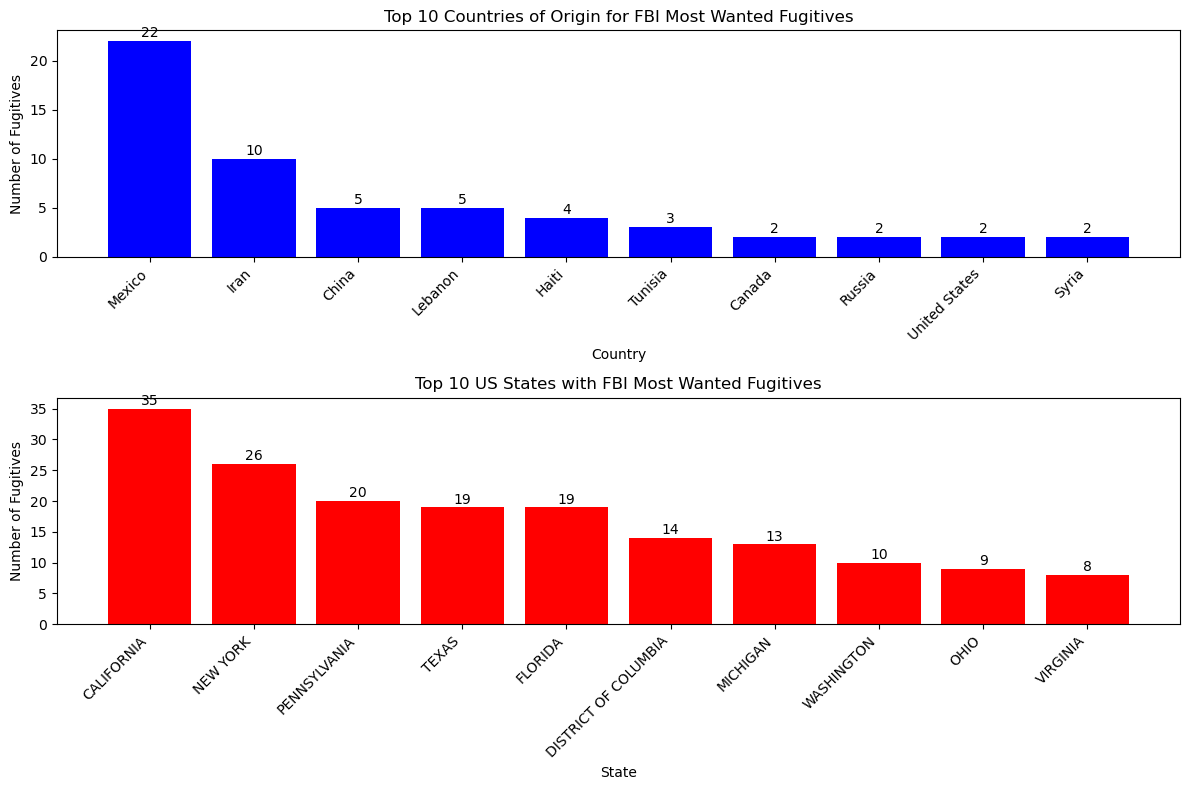

In [717]:
# Block 5: Create Bar Charts ###WORKS###
def createBarCharts(dfMap):
    #Create bar charts showing top countries and states with most fugitives
    
    # Split data by type
    dfCountries = dfMap[dfMap['type'] == 'country']
    dfStates = dfMap[dfMap['type'] == 'state']
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create top countries chart
    
    plt.subplot(2, 1, 1)
    
    # Get top 10 countries and sort by count
    topCountries = dfCountries.sort_values('count', ascending=False).head(10)
    
    # Create bars
    bars = plt.bar(topCountries['location'], topCountries['count'], color='blue')
    
    # Add labels
    plt.title('Top 10 Countries of Origin for FBI Most Wanted Fugitives')
    plt.xlabel('Country')
    plt.ylabel('Number of Fugitives')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               str(int(height)), ha='center', va='bottom')

    # Create top states chart

    plt.subplot(2, 1, 2)
    
    # Get top 10 states and sort by count
    topStates = dfStates.sort_values('count', ascending=False).head(10)
    
    # Create bars
    bars = plt.bar(topStates['location'], topStates['count'], color='red')
    
    # Add labels
    plt.title('Top 10 US States with FBI Most Wanted Fugitives')
    plt.xlabel('State')
    plt.ylabel('Number of Fugitives')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               str(int(height)), ha='center', va='bottom')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    return dfCountries, dfStates

# Usage:
dfCountries, dfStates = createBarCharts(dfMap)

Gathering reward data...


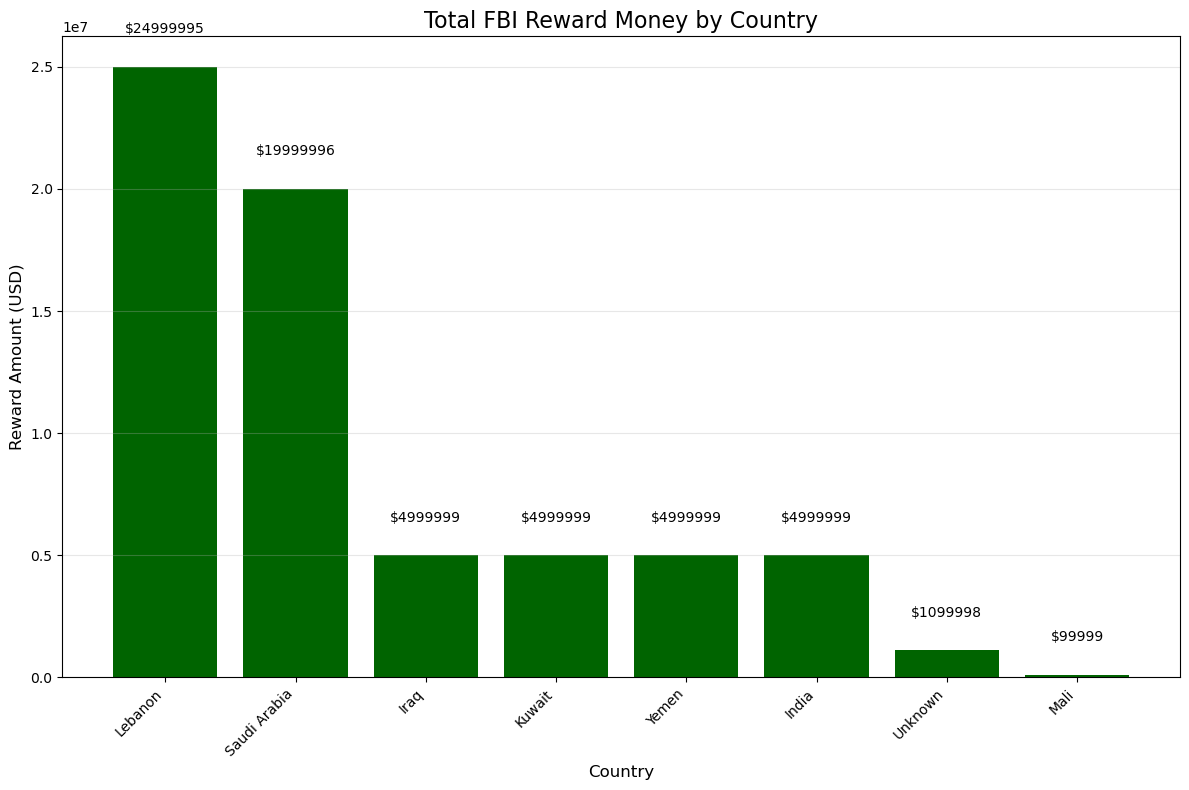

In [719]:
# Block 6: Which country is causing the most trouble?? ###WORKS###
def visualizeRewardsByCountry():
    # gather FBI reward data by country and create visualization
    
    # Initialize dictionary to store reward by country
    countryRewards = {}
    # Track individual rewards for top listing
    allRewards = []
    
    # Process reward data from FBI API
    currentPage = 1
    maxPages = 10  # Limit to 10 pages
    
    print("Gathering reward data...")
    
    for page in range(1, maxPages + 1):
        # Fetch page of FBI data
        pageData = fetchFbiData(page)
        if not pageData.get('items'):
            break
            
        # Process each person
        for person in pageData.get('items', []):
            # Extract basic information
            name = person.get('title', 'Unknown Person')
            reward = person.get('reward_max', 0)
            
            # Convert reward to number if it's a string

                        # Try to convert reward to a number regardless of its type
            try:
                rewardStr = str(reward).replace('$', '').replace(',', '')
                rewardNum = int(rewardStr)
                # If conversion succeeded, use the numeric value
                reward = rewardNum
            except:
                # If conversion failed, default to 0
                reward = 0
           
            
            # Skip if no reward
            if reward <= 0:
                continue
                
            # Determine country
            countryName = "Unknown"
            placeOfBirth = person.get('place_of_birth', '')
            
            if placeOfBirth:
                if any(usName in placeOfBirth for usName in ["United States", "USA", "U.S."]):
                    countryName = "United States"
                else:
                    for name in countries.keys():
                        if name.lower() in placeOfBirth.lower():
                            countryName = name
                            break
            
            # Record reward data
            if countryName not in countryRewards:
                countryRewards[countryName] = 0
            countryRewards[countryName] += reward
            
            # Add to individual rewards list
            allRewards.append({
                'name': name,
                'country': countryName,
                'reward': reward
            })
    
    # Create visualization
    if countryRewards:
        # Sort countries by reward amount
        sortedCountries = sorted(countryRewards.items(), key=lambda x: x[1], reverse=True)
        topCountries = sortedCountries[:10]



                # Convert the list of tuples into two separate lists
        countryNames = []    # Will store just the country names
        rewardAmounts = []   # Will store just the reward amounts
        
        # For each (country, amount) tuple in topCountries list
        for countryTuple in topCountries:
            countryNames.append(countryTuple[0]) # Add country name (first element) to countryNames list
            rewardAmounts.append(countryTuple[1]) # Add reward amount (second element) to rewardAamounts list
        
        # Create bar chart
        plt.figure(figsize=(12, 8))
        bars = plt.bar(countryNames, rewardAmounts, color='darkgreen')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            label_y_position = height + 0.05 * max(rewardAmounts)
            label_x_position = bar.get_x() + bar.get_width()/2
            label_text = "$" + str(height)
            plt.text(label_x_position, label_y_position, label_text, ha='center', va='bottom')
                
        # Style the chart
        plt.title("Total FBI Reward Money by Country", fontsize=16)
        plt.xlabel("Country", fontsize=12)
        plt.ylabel("Reward Amount (USD)", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return countryRewards

# After loading coordinate data
rewardData = visualizeRewardsByCountry()

In [499]:
# Block 7: Re Import ###WORKS###
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

In [500]:
# Block 8: Extract a criminal's name ###WORKS###
#This function is designed to extract a criminal's name from an HTML table cell.
#It takes a parameter cell from the Wikipedia page.
#The function checks if the cell contains an tag <a> (cell.find('a'))
#It extracts the text from the link with get_text()

# Function to extract criminal name from cell
def extractName(cell):
    # Extract name from cell text or link
    if cell.find('a'):
        return cell.find('a').get_text().strip()
    else:
        return cell.get_text().strip()

In [468]:
# Block 9: Scraping Wikipedia for FBI Most Wanted Data ###WORKS###
def scrapeFbiMostWantedByDecade(decade):
    # Here I limit my self on how many fugitives i inspect per page too just the ones with the longest time on the list per gae.
    url = "https://en.wikipedia.org/wiki/FBI_Ten_Most_Wanted_Fugitives,_" + decade
    print("Scraping data for " + decade + "...")
    
    try:
        # Get and parse the webpage
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        criminalsData = []
        
        # Find all criminals in wikitables - A wikitable is a box of rows and columns used to show data, on a page
        for table in soup.find_all('table', class_='wikitable'): #######
            # For each row, this finds all table cells, including both data cells (<td>) and header cells (<th>).
            for row in table.find_all('tr')[1:]:  # Skip header row
                cells = row.find_all(['td', 'th'])
                if len(cells) < 2:
                    continue
                
                
                # Initialize an empty dictionary for the criminal record
                criminal = {}
                
                # Add name
                criminal['name'] = extractName(cells[0])
                # Add number
                if len(cells) > 1:
                    numberText = cells[1].get_text()
                    criminal['number'] = numberText.strip()
                else:
                    criminal['number'] = " "
                # Add date added
                if len(cells) > 2:
                    dateText = cells[2].get_text()
                    criminal['date_added'] = dateText.strip()
                else:
                    criminal['date_added'] = " "
                # Add time on list
                if len(cells) > 3:
                    timeText = cells[3].get_text()
                    criminal['time_on_list'] = timeText.strip()
                else:
                    criminal['time_on_list'] = " "
                
                # Only keep valid records
                if criminal['name'] and criminal['date_added'] != "Unknown":
                    criminalsData.append(criminal)


        
        return criminalsData
    except: # instead of showing error, nothing happens
        return []





In [469]:
# # Block: 10 Scrape by Decade ###WORKS###
def scrapeFbiDataAllDecades():
    
    decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
    allCriminals = []
    
    for decade in decades: # Get data for this decade
        criminalData = scrapeFbiMostWantedByDecade(decade)
        
        for criminal in criminalData: # Add decade info to each record
            criminal['decade'] = decade
        
        allCriminals.extend(criminalData) # Add to master list
    
    return allCriminals

In [470]:
# Block: 11: Parse Data ###WORKS###
def parseDate(dateStr):
    #Extract year from a date string using regex
    yearMatch = re.search(r'(\d{4})', dateStr)
    if yearMatch:
        return datetime.strptime(yearMatch.group(1), '%Y')
    return None

def calculateYearsOnList(criminal):
    #Calculate how many years a criminal was on the FBI list
    
    #This function:
    #1. Gets the year when the criminal was added to the list
    #2. Determines when they were removed using different text patterns
    #3. Calculates the span of years they were listed
    #4. Returns a list of all years they appeared on the list
    
    # Get when the criminal was added to the list
    dateAdded = parseDate(criminal.get('date_added', 'Unknown'))
    if not dateAdded:
        return []
        
    startYear = dateAdded.year
    timeListed = criminal.get('time_on_list', '').lower()
    endYear = None
    
    # Check for numeric year patterns like "18 years"
    if re.search(r'(\d+)\s+years?', timeListed):
        years = int(re.search(r'(\d+)\s+years?', timeListed).group(1))
        endYear = startYear + years
    
    # Check for explicit year ranges like "1970-1975" or "1970 to 1975"
    # Complicated Reggex made by chat gpt to scrape wiki
    elif re.search(r'(\d{4})\s*(?:to|-)\s*(\d{4})', timeListed):
        endYear = int(re.search(r'(\d{4})\s*(?:to|-)\s*(\d{4})', timeListed).group(2))
    
    # Check for text number descriptions like "five years"
    else:
        textNumbers = {
            'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
            'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
            'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15,
            'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19, 'twenty': 20
        }
        

        word_forms = list(textNumbers.keys())
        found_match = False
        
        for word in word_forms:
            pattern = word + " year"
            
            if pattern in timeListed:
                number_value = textNumbers[word]
                endYear = startYear + number_value
                found_match = True       
                break
                
    # If we couldn't determine end year, return empty list
    if not endYear:
        return []
    
    # Store time information in the criminal dictionary
    criminal['time_span'] = endYear - startYear
    criminal['entry_year'] = startYear
    
    # Return list of all years the criminal was on the list
    return list(range(startYear, endYear + 1))


In [471]:
# Block 12: Finding Longest-Wanted Fugitives by Decade ###WORKS###
def analyzeLongestFugitivesByDecade(allCriminals, topCount=10):
    
    # Calculate how long each criminal was wanted
    for criminal in allCriminals:
        criminal['years_on_list'] = calculateYearsOnList(criminal)
    
    # To group criminals by decade create a dictionary where each decade has its own list of criminals
    criminalsByDecade = defaultdict(list)
    for criminal in allCriminals:
        
        decade = criminal.get('decade', '') # Get which decade this criminal belongs to 
        
        if decade: # Only add if decade is valid
            criminalsByDecade[decade].append(criminal)
    
    decadeTopFugitives = {}  # Will store top criminals by decade
    decadeStats = {}          # Will store statistics by decade
    
    # Process each decade
    for decade, criminals in criminalsByDecade.items():
        # Get the time span for each criminal in this decade
        timeSpans = []
        for criminal in criminals:
            timeSpan = criminal.get('time_span', 0)  # Get how long they were wanted (default 0)
            timeSpans.append(timeSpan)
        
        
        sortedCriminals = [] # Sort criminals from longest to shortest wanted time
        criminalsCopy = list(criminals) # Make a copy of the criminals list to sort
        
        # Sort the copy by time_span value in descending order
        criminalsCopy.sort(key=lambda criminal: criminal.get('time_span', 0), reverse=True)
        sortedCriminals = criminalsCopy
        
        # Take only the top # criminals (default 10)
        topFugitives = sortedCriminals[:topCount]
        decadeTopFugitives[decade] = topFugitives

    
    return decadeStats, decadeTopFugitives


In [472]:
# Block 13: Yearly Timeline Chart ###WORKS###
def createYearlyTimeline(decadeTopFugitives):
    
    # Set yearly count dictionary (1950-20010)
    yearlyCounts = {year: 0 for year in range(1950, 2010)}
    
    # Collect all top fugitives from all decades
    allFugitives = []
    for fugitives in decadeTopFugitives.values():
        allFugitives.extend(fugitives)
    
    # Count each fugitives active years
    for criminal in allFugitives:
        entryYear = criminal.get('entry_year')
        timeSpan = criminal.get('time_span', 0)
        
        if entryYear and timeSpan:
            # Increment count for each year this fugitive was active
            for year in range(entryYear, entryYear + timeSpan):
                if 1950 <= year < 2010:  # Only include years up to 2010
                    yearlyCounts[year] += 1
    
    # Sort data
    years = sorted(yearlyCounts.keys())
    counts = [yearlyCounts[year] for year in years]
    
    # Create visualization
    plt.figure(figsize=(16, 8))
    plt.plot(years, counts, marker='o', markersize=4, linewidth=2)
    plt.title('Number of FBI Most Wanted Fugitives Active Each Year (ONLY TOP # CRIMINALS PER DECADE)')
    plt.xlabel('Year')
    plt.ylabel('Number of Fugitives')
    plt.grid(True, alpha=0.3)
    
    # Add decade reference lines
    for decade in range(1950, 2010, 10):
        plt.axvline(x=decade, color='gray', linestyle='--', alpha=0.5)
    
    # Formating
    plt.xticks(range(1950, 2010, 5))
    
    
    plt.show()
    


Starting FBI Most Wanted data analysis...
Scraping data for 1950s...
Scraping data for 1960s...
Scraping data for 1970s...
Scraping data for 1980s...
Scraping data for 1990s...
Scraping data for 2000s...
Scraping data for 2010s...
Scraping data for 2020s...
Found 621 total criminals across all decades


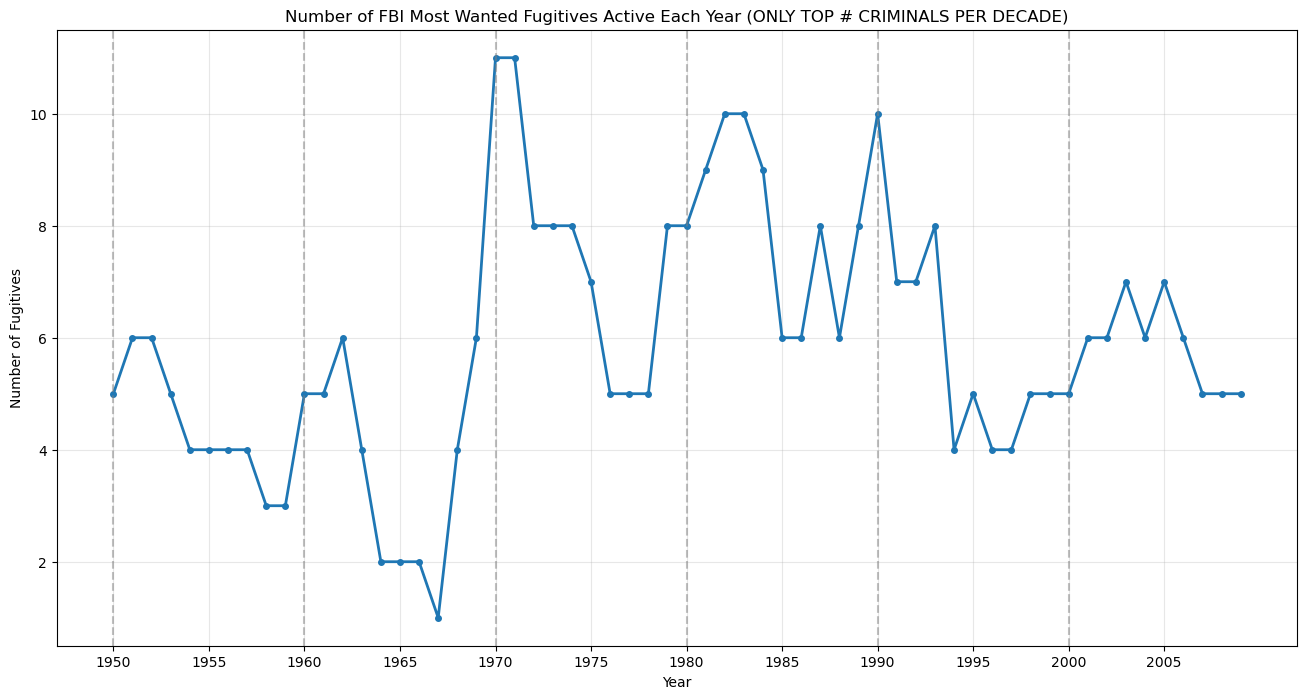

In [473]:
# Block 14: Run 7-12 ###WORKS###
print("Starting FBI Most Wanted data analysis...")
    
# Scrape data for all decades
allCriminals = scrapeFbiDataAllDecades()
print("Found " + str(len(allCriminals)) + " total criminals across all decades")

# Analyze longest fugitives by decade
decadeStats, decadeTopFugitives = analyzeLongestFugitivesByDecade(allCriminals)

# Create timeline visualization
createYearlyTimeline(decadeTopFugitives)

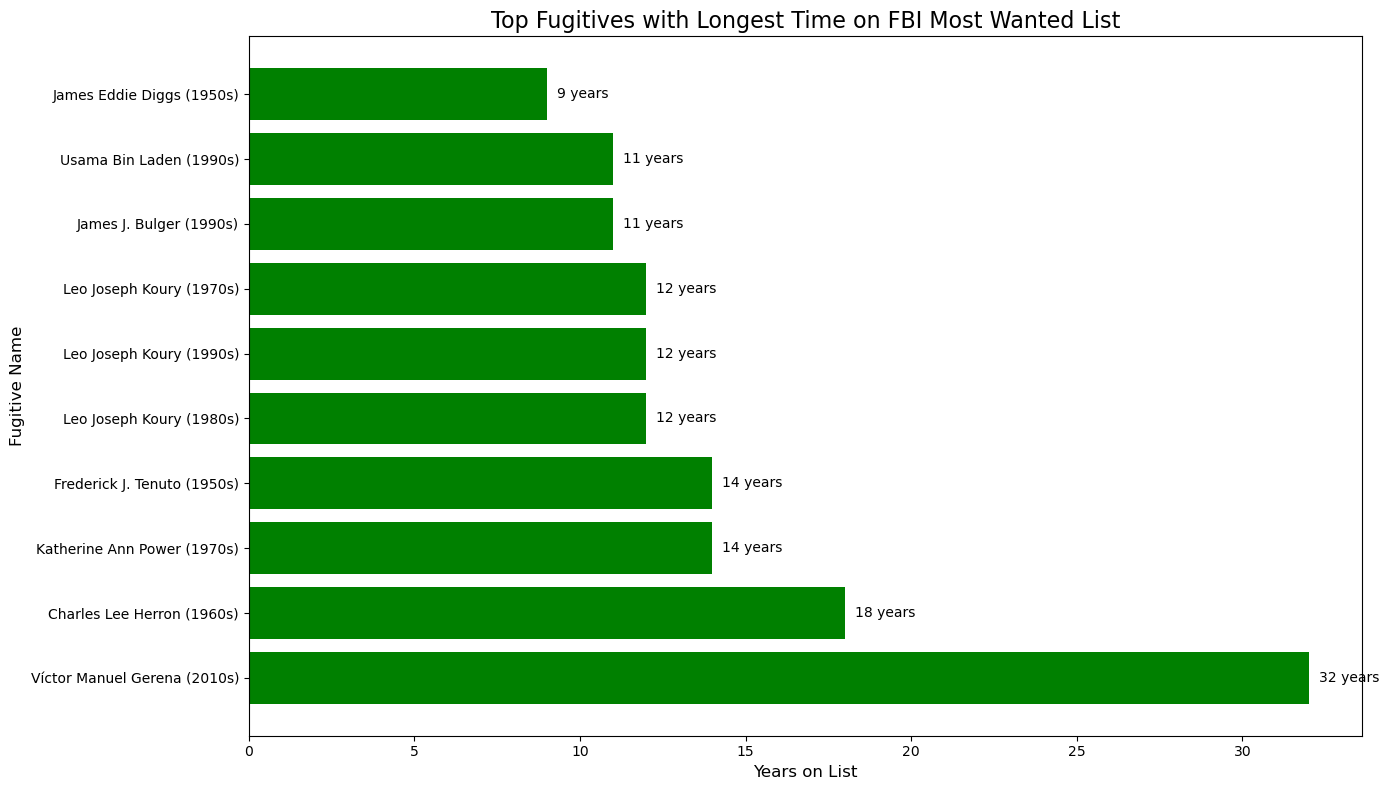

In [474]:
# Block 14: Rewards Bar Chart ###WORKS###
def visualizeTopFugitivesOverall(decadeTopFugitives, top_n=10):
    # Collect all fugitives
    all_fugitives = []
    for decade in decadeTopFugitives:
        decade_fugitives = decadeTopFugitives[decade]
        for fugitive in decade_fugitives:
            all_fugitives.append(fugitive)
    
    # Sorting
    for i in range(len(all_fugitives)):
        for j in range(i + 1, len(all_fugitives)):
            time_i = all_fugitives[i].get('time_span', 0)
            time_j = all_fugitives[j].get('time_span', 0)
            if time_i < time_j:
                # Swap
                temp = all_fugitives[i]
                all_fugitives[i] = all_fugitives[j]
                all_fugitives[j] = temp
    
    # Get top N fugitives
    top_fugitives = []
    counter = 0
    for fugitive in all_fugitives:
        if counter < top_n:
            top_fugitives.append(fugitive)
            counter += 1
        
    
    # Prepare data for plotting
    names = []
    time_spans = []
    
    for fugitive in top_fugitives:
    
        name = str(fugitive.get('name', ''))
        decade = str(fugitive.get('decade', ''))
        full_name = name + " (" + decade + ")"
        names.append(full_name)
        time_span = fugitive.get('time_span', 0)
        time_spans.append(time_span)

    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(names, time_spans, color='green')
    
    # Add text labels
    i = 0
    for bar in bars:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height()/2
        plt.text(width + 0.3, y_pos, str(width) + " years", va='center')
        i += 1
    
    # Add titles and labels
    plt.title('Top Fugitives with Longest Time on FBI Most Wanted List', fontsize=16)
    plt.xlabel('Years on List', fontsize=12)
    plt.ylabel('Fugitive Name', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


# In the main function, after analyzing data:
visualizeTopFugitivesOverall(decadeTopFugitives)